# Setup
## Imports

In [1]:
import os
from os import environ
from os.path import join
import glob
from tqdm import tqdm

import requests
from bs4 import BeautifulSoup

# # geoprocessing imports
import geopandas as gpd
import pandas as pd
import numpy as np

# raster processing imports
import xarray as xr
import rioxarray

# Functions definition

In [2]:
# Functions

## Parameters

In [3]:
# main path
data_folder = '../data'

# paths
aoi_path = join(data_folder, 'admin', 'adm2.geojson')
chirps_path = join(data_folder, 'chirps')

# start / end dates
start_date="2020-01-01"
end_date="2025-12-30"

# Main code
## Define the AOI

In [4]:
aoi_gdf = gpd.read_file(aoi_path)

aoi_utm_crs = aoi_gdf.estimate_utm_crs()
aoi_geom = aoi_gdf.to_crs(aoi_utm_crs).dissolve().buffer(5000).to_crs(4326).iloc[0]

## Download data

In [11]:
base_url = 'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/tifs/'
for _i in range(3):
    try:
        resp = requests.get(base_url)
        if resp.status_code == 200:
            break # exit retry loop
    except:
        pass

In [12]:
url_list = []
soup = BeautifulSoup(resp.content, "html.parser")
for tr in soup.find("table", {"id": "list"}).find_all("tr"):
    a = tr.find("a", href=True)
    if not a:
        continue
    
    url = a.attrs["href"]
    if url.startswith("chirps"):
        url_date = pd.to_datetime([url[12:19]], yearfirst=True).astype('datetime64[ns]')
        if url_date >= start_date and  url_date <= end_date:
            url_list.append(base_url+url)
len(url_list)

69

In [14]:
for url in tqdm(url_list):
    filename = os.path.basename(url).removesuffix(".tif.gz")
    filename = filename[-7:] + '.' + filename[:-7] + 'tif'
    if os.path.exists(join(chirps_path, filename)):
        continue

    # read the file directly from url
    da = rioxarray.open_rasterio("/vsigzip//vsicurl/"+url, masked=True)
    da = da.rio.write_nodata(-9999.)

    # clip to AOI
    da = da.rio.clip([aoi_geom]).load()

    # export TIFF
    da.rio.to_raster(join(chirps_path, filename), compress='deflate', predictor=2)

100%|██████████| 69/69 [06:44<00:00,  5.86s/it]


## Perform zonal stats

In [5]:
from rasterio.enums import Resampling
from rasterstats import zonal_stats

file_list = glob.glob(os.path.join(chirps_path, "*.tif"))

# define a model to reproject all the other rasters
df_list = []
for file in tqdm(file_list):
    date = pd.to_datetime(os.path.basename(file)[:7].replace('.', '-')+'-01', yearfirst=True)

    # open the raster and extract
    with rioxarray.open_rasterio(file) as da:
        da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
        da = da.astype('float32').where(da != -9999.).rio.set_nodata(np.nan)
    
        # generate the zonal stats
        stats_dict = zonal_stats(aoi_gdf.to_crs(da.rio.crs), da.data[0], stats=['mean', 'max', 'min', 'std'], affine=da.rio.transform(), nodata=np.nan)
        stats_df = pd.DataFrame(stats_dict)
        stats_df['month'] = date
        df_list.append(stats_df)

stats_df = pd.concat(df_list).join(aoi_gdf['district']).reset_index(drop=True)
stats_df = stats_df.sort_values(['month', 'district'])

100%|██████████| 69/69 [00:24<00:00,  2.83it/s]


In [6]:
# export
stats_df.to_csv(join(data_folder, 'indicators', 'precipitations.csv'))

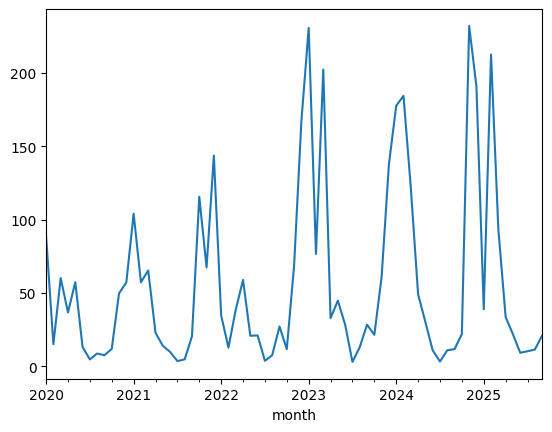

In [7]:
stats_df[stats_df['district']=='Northern Buttes District'].set_index('month')['mean'].plot();

## Generate yearly aggregation

In [28]:
modis_file_list = glob.glob(join(chirps_path, '*.tif'))
years_list = ['2020', '2021', '2022', '2023', '2024', '2025']

df_list = []
for year in tqdm(years_list):
    export_file_tiff = join(data_folder, 'aggregates', f'precipitations_{year}.tif')

    # if os.path.exists(export_file_tiff):
    #     continue

    file_list = sorted([f for f in modis_file_list if os.path.basename(f).startswith(str(year))])

    da_list = []
    # generate a rasters time series for the year
    for file in file_list:
        date = np.datetime64(os.path.basename(file)[:7].replace('.', '-')+'-01')
               
        with rioxarray.open_rasterio(file) as da:
            da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
            da = da.astype('float32').where(da != -9999.).rio.set_nodata(np.nan)
            da_list.append(da)
   
    ds_concat = xr.concat(da_list, dim='time').to_dataset(name='precipitations')
    ds_concat = ds_concat.rio.set_crs(aoi_utm_crs)
    
    # generate cumulated tiff for the year
    ds_concat['precipitations'].sum(dim='time', skipna=False).rio.set_nodata(np.nan).rio.to_raster(export_file_tiff, compress='deflate', predictor=2)

100%|██████████| 6/6 [00:01<00:00,  5.63it/s]
